# Milestone III

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score


In [ ]:
import re
import pickle
import string
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import nltk
from collections import Counter
from textstat import textstat
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import random

# NLTK imports
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# NLTK downloads
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("vader_lexicon")

# Ignore warnings
warnings.filterwarnings('ignore')

random.seed(42)
np.random.seed(42)


[nltk_data] Downloading package punkt to /Users/lila/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lila/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
df = pd.read_csv('YoutubeCommentsDataSet.csv')

Podział na zbirory walidacyjne, treningowy, testowy

In [5]:
from sklearn.model_selection import train_test_split

# split the dataset into train (85%) and validation (15%)
df, validation_df = train_test_split(df, test_size=0.15, stratify=df['Sentiment'], random_state=42)
df, test_df = train_test_split(df, test_size=0.1275, stratify=df['Sentiment'], random_state=42)
validation_df.to_csv("validation_set.csv", index=False)

### TF-IDF Embedding

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=3000,        
    ngram_range=(1, 2),       # Unigrams + bigrams 
    stop_words='english',    
    sublinear_tf=True,        
    norm='l2'                 # Normalize each vector
)

In [7]:
class TfidfEmbedding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=3000,
            ngram_range=(1, 2),
            stop_words='english',
            sublinear_tf=True
        )

    def fit(self, X, y=None):
        self.vectorizer.fit(X['Comment_preprocessed'])
        return self


    def transform(self, X):
        return self.vectorizer.transform(X['Comment_preprocessed'])


## Inżynieria cech

In [8]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')  # Download WordNet corpus
nltk.download('omw-1.4')  # Optional: Better word sense
nltk.download('punkt')

wnl = WordNetLemmatizer()

def preprocess_text(text):
    # Get all stopwords but preserve negations
    all_stop_words = set()
    for lang in stopwords.fileids():
        all_stop_words.update(stopwords.words(lang))  

    # Stopwords, które nie są usuwane
    negation_words = {"no", "not", "never", "none", "nowhere", "nobody", "nothing", "neither", "nor", 
                    "isn't", "wasn't", "weren't", "doesn't", "don't", "didn't", "hasn't", "haven't", 
                    "hadn't", "won't", "wouldn't", "shan't", "shouldn't", "can't", "couldn't", "mustn't"}

    # Remove stopwords except negations
    filtered_stop_words = all_stop_words - negation_words  

    words = word_tokenize(text.lower())  # Tokenize & lowercase
    filtered_words = [wnl.lemmatize(word) for word in words if word.isalnum() and word not in filtered_stop_words]  
    return ' '.join(filtered_words)  # Join words back into a sentence

[nltk_data] Downloading package wordnet to /Users/lila/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lila/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lila/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Funkcje pomocnicze

In [35]:
def preprocess_data(df):
    
    df = df.dropna()

    # dropping consecutive duplicates
    df = df.loc[df['Comment'] != df['Comment'].shift()].reset_index(drop=True)

    df['Comment_preprocessed'] = df['Comment'].apply(preprocess_text)
    df['Comment_preprocessed'] = df['Comment_preprocessed'].apply(lambda x: re.sub(r'\d+', '', x))

    return df


# Funkcja do obliczania Sentiment Score za pomocą NLTK
sia = SentimentIntensityAnalyzer()
def sentiment_score(comment):
    return sia.polarity_scores(comment)['compound']


# Funkcja do liczenia liczby zaimków osobistych
personal_pronouns = {"i", "me", "my", "mine", "myself", "we", "us", "our", "ours", "ourselves",
                     "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself",
                     "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
                     "theirs", "themselves"}

def count_personal_pronouns(comment):
    words = word_tokenize(comment.lower())
    return sum(1 for word in words if word in personal_pronouns)


# Funkcja do analizy złożoności zdań (np. liczba fraz, słów)
connectors = ["and", "but", "so", "because", "which", "that", "then", "if", "or"]
def sentence_complexity(comment):
    words = word_tokenize(comment)
    phrases = re.split(r'\b(?:' + '|'.join(connectors) + r')\b', comment)

    num_words = len(words)
    num_phrases = len(phrases)

    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    avg_phrase_length = num_words / num_phrases if num_phrases > 0 else 0
    unique_word_ratio = len(set(words)) / num_words if num_words > 0 else 0

    return {
        "Number_of_phrases": num_phrases,
        "Number_of_words": num_words,
        "Avg_phrase_length": avg_phrase_length,
        "Avg_word_length": avg_word_length,
        "Unique_word_ratio": unique_word_ratio
    }


# Funkcja do obliczania readability score
def readability_score(comment):
    return textstat.flesch_reading_ease(comment)


# Funkcja do liczenia negacji
def negation_count(comment):
    negations = {"not", "never", "no", "none", "cannot", "nothing","dont","nah",'wont','cant','doesnt','shouldnt',"shouldn't","doesn't"
                 "don't","won't","wouldn't", "can't","nobody",'neither','nope',"ain't","nowhere",'wouldnt'}
    words = word_tokenize(comment.lower())
    return sum(1 for word in words if word in negations)


# Funkcja do liczenia rzadkich słów
def rare_word_count(comment, all_words):
    words = word_tokenize(comment.lower())
    rare_words = [word for word in words if all_words[word] < 10]  # Możemy dostosować próg (tutaj <10)
    return len(rare_words)

In [16]:
class CustomFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy() 
        
        comments = X['Comment']
        features = pd.DataFrame()

        comments = comments.fillna('').astype(str)

        features['Sentiment_Score_nltk'] = comments.apply(sentiment_score)
        features['Starts_with_i'] = comments.str.startswith("i")
        features['Comment_Length'] = comments.str.len()

        features["Personal_Pronoun_count"] = comments.apply(count_personal_pronouns)
        features["Readability_Score"] = comments.apply(readability_score)
        features["Negation_Count"] = comments.apply(negation_count)

        df_complexity = comments.apply(lambda x: sentence_complexity(x))
        df_complexity = pd.DataFrame(df_complexity.tolist(), index=X.index)
        features = pd.concat([features, df_complexity], axis=1)

        all_words = Counter(' '.join(comments).lower().split())
        features['Rare_Word_Count'] = comments.apply(lambda x: rare_word_count(x, all_words))

        return features.to_numpy()


### Pipeline

In [17]:
df = preprocess_data(df)

## Transformer do sprawdzenia, czy bert daje lepsze wyniki niż tfidf

TF-IDF daje nam 3000 cech. PCA eliminuje, z zachowaniem wariancji, mniej niż połowę z nich. W celu zmniejszenia czasu wywołania oraz poprawie efektywności wprowadzamy nowy embedding. Bert generuje mniej cech oraz, w przeciwieństwie do TF-IDF, bierze pod uwagę semantykę -- znaczenie słów o wielu znaczeniach. Testując oba pipeliny przekonałyśmy się, że bert daje lepsze wyniki i zdecydowałyśmy się na zastąpienie nim embeddingu z TF-IDF.

In [18]:
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class BertSentenceEmbedding(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model_name = model_name

    def fit(self, X, y=None):
        self.model = SentenceTransformer(self.model_name)
        return self

    def transform(self, X):
        # Handle DataFrame or Series
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0]  # assume first column is text
        return np.array(self.model.encode(X.tolist(), show_progress_bar=False))



### Budujemy pipeline

Dwie alternatywy dla text_pipeline: tfidf embedding daje 3000 kolumn, bert daje około 300. Bert nie potrzebuje PCA - jest to gęsta macierz, w przeciwieństwie do tfidf.

In [ ]:
from sklearn.decomposition import PCA

# Alternatywny pipeline dla TFIDF
# text_pipeline = Pipeline([
#     ('tfidf', TfidfEmbedding()),
#     ('pca', PCA(n_components=1600))
# ])

text_pipeline = Pipeline([
    ('bert', BertSentenceEmbedding())  # no PCA needed, BERT gives dense vectors
])

custom_feat_pipeline = Pipeline([
    ('custom', CustomFeatureExtractor()),
    ('scaler', StandardScaler())
])

combined_features = FeatureUnion([
    ('text', text_pipeline),
    ('custom', custom_feat_pipeline)
])

In [20]:
df.head()

Comment Sentiment  \
0  chega a ser ridícula a pergunta o senhor não f...   neutral   
1  i think its really a testament to your explana...  positive   
2  thankyou for the effort you put into your vide...  positive   
3  thanks for being a lesson for millions of us y...  positive   
4  when a high youtuber explains biology better i...  positive   

                                Comment_preprocessed  
0  chega ridícula pergunta senhor financia algum ...  
1  testament explanation skill schrodinger equati...  
2  thankyou effort put video spend thousand video...  
3  lesson million person spreading message remain...  
4  high youtuber explains biology  minute sober q...

In [21]:
X_raw = df[['Comment', 'Comment_preprocessed']]
y = df['Sentiment']

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)


### Sprawdzamy ile z cech z PCA warto zachować 

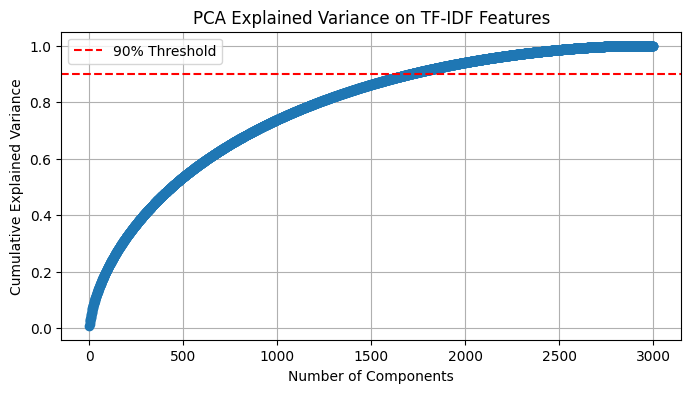

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

tfidf_only_pipeline = Pipeline([
    ('tfidf', TfidfEmbedding())
])

tfidf_features = tfidf_only_pipeline.fit_transform(X_train)

tfidf_dense = tfidf_features.toarray() 

pca = PCA().fit(tfidf_dense)
explained = np.cumsum(pca.explained_variance_ratio_)

# Step 5: Plot it
plt.figure(figsize=(8, 4))
plt.plot(explained, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance on TF-IDF Features')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Threshold')
plt.legend()
plt.show()

In [23]:
combined_features.fit(X_train)

FeatureUnion(transformer_list=[('text',
                                Pipeline(steps=[('bert',
                                                 BertSentenceEmbedding())])),
                               ('custom',
                                Pipeline(steps=[('custom',
                                                 CustomFeatureExtractor()),
                                                ('scaler',
                                                 StandardScaler())]))])

In [24]:
X_train_features = combined_features.transform(X_train)
X_test_features = combined_features.transform(X_test)


In [25]:
print(X_train_features.shape)

(8079, 396)


## Test podstawowych modeli

In [26]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K Nearest Neighbours': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'LightGBM': LGBMClassifier()
}

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

results = []

for name, model in models.items():
    print(f"\n{name}")
    
    model.fit(X_train_features, y_train)
    y_pred = model.predict(X_test_features)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    results.append({
        'Model': name,
        'Accuracy': acc
    })

# Show all results in a table
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\nSummary:")
print(results_df.to_string(index=False))



Logistic Regression
Accuracy: 0.7916
Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.55      0.59       262
     neutral       0.66      0.68      0.67       506
    positive       0.87      0.89      0.88      1252

    accuracy                           0.79      2020
   macro avg       0.73      0.70      0.71      2020
weighted avg       0.79      0.79      0.79      2020


K Nearest Neighbours
Accuracy: 0.7252
Classification Report:


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


              precision    recall  f1-score   support

    negative       0.49      0.46      0.47       262
     neutral       0.58      0.53      0.55       506
    positive       0.82      0.86      0.84      1252

    accuracy                           0.73      2020
   macro avg       0.63      0.62      0.62      2020
weighted avg       0.72      0.73      0.72      2020


Support Vector Machine
Accuracy: 0.7797
Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.45      0.54       262
     neutral       0.63      0.70      0.66       506
    positive       0.86      0.88      0.87      1252

    accuracy                           0.78      2020
   macro avg       0.72      0.68      0.69      2020
weighted avg       0.78      0.78      0.78      2020


Decision Tree
Accuracy: 0.6545
Classification Report:
              precision    recall  f1-score   support

    negative       0.38      0.39      0.38       262
     neutr

### Balansowanie zbioru -- SMOTE

Cechy z BERT nie są wartościami otrzymanymi używając przekształceń liniowych. Są one wynikiem przetworzenia tekstu przez wcześniej wytrenowany model. Nałożenie na nich balansowania SMOTE nie ma większego sensu - krok ten pomijamy.

In [90]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

results = []

for name, model in models.items():
    print(f"\n{name}")
    
    # SMOTE + Classifier pipeline
    smote_model_pipeline = ImbPipeline([
        ('smote', SMOTE()),
        ('clf', model)
    ])
    
    # Fit and predict
    smote_model_pipeline.fit(X_train_features, y_train)
    y_pred = smote_model_pipeline.predict(X_test_features)
    
    # Evaluation
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    results.append({
        'Model': name,
        'Accuracy': acc
    })

# Show all results in a table
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\nSummary:")
print(results_df.to_string(index=False))



Logistic Regression
Accuracy: 0.7669
Classification Report:
              precision    recall  f1-score   support

    negative       0.53      0.73      0.62       355
     neutral       0.61      0.71      0.65       684
    positive       0.94      0.80      0.86      1685

    accuracy                           0.77      2724
   macro avg       0.69      0.75      0.71      2724
weighted avg       0.80      0.77      0.78      2724


K Nearest Neighbours
Accuracy: 0.5639
Classification Report:
              precision    recall  f1-score   support

    negative       0.30      0.70      0.42       355
     neutral       0.44      0.65      0.53       684
    positive       0.95      0.50      0.66      1685

    accuracy                           0.56      2724
   macro avg       0.57      0.62      0.53      2724
weighted avg       0.74      0.56      0.59      2724


Support Vector Machine
Accuracy: 0.7540
Classification Report:
              precision    recall  f1-score   suppo

Aby dane były kopatybilne z każdym z modeli przemapowałyśmy sentyment na dodatnie liczby całkowite: 
0 - negative, 1 - neutral, 2 - positive

In [28]:
mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Vectorized mapping
y_train_enc = np.vectorize(mapping.get)(y_train)
y_test_enc = np.vectorize(mapping.get)(y_test)

In [29]:
print("Encoded y_train:", y_train_enc[:5])  # First 10 encoded labels
print("Encoded y_test:", y_test_enc[:5])

print("y_train:", y_train[:5])  # First 10 encoded labels
print("y_test:", y_test[:5])

Encoded y_train: [2 1 1 2 2]
Encoded y_test: [1 2 1 0 0]
y_train: 3184    positive
4189     neutral
8514     neutral
7347    positive
3238    positive
Name: Sentiment, dtype: object
y_test: 8171     neutral
6476    positive
2122     neutral
5399    negative
304     negative
Name: Sentiment, dtype: object



Logistic Regression
Accuracy: 0.7720
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.75      0.63       355
           1       0.62      0.71      0.66       684
           2       0.94      0.80      0.87      1685

    accuracy                           0.77      2724
   macro avg       0.70      0.75      0.72      2724
weighted avg       0.80      0.77      0.78      2724



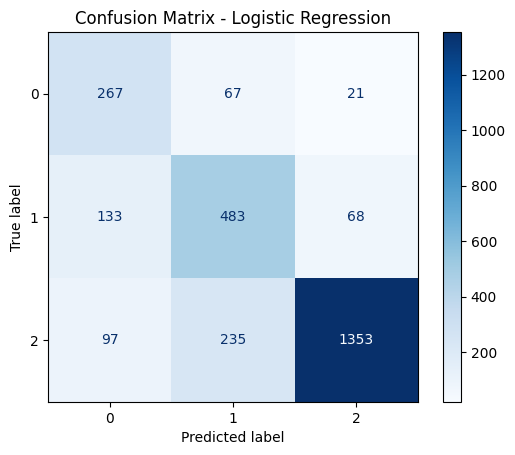


Random Forest
Accuracy: 0.7753
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.74      0.63       355
           1       0.66      0.64      0.65       684
           2       0.89      0.84      0.86      1685

    accuracy                           0.78      2724
   macro avg       0.70      0.74      0.71      2724
weighted avg       0.79      0.78      0.78      2724



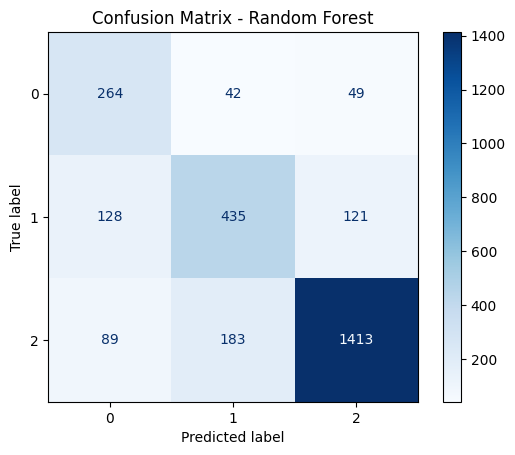


K Nearest Neighbours
Accuracy: 0.5797
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.68      0.42       355
           1       0.45      0.65      0.53       684
           2       0.95      0.53      0.68      1685

    accuracy                           0.58      2724
   macro avg       0.57      0.62      0.54      2724
weighted avg       0.74      0.58      0.61      2724



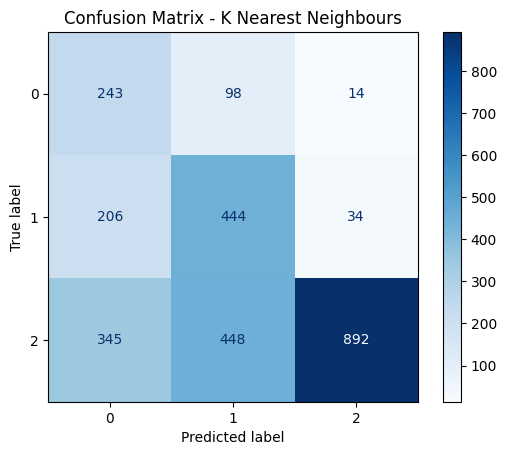


Support Vector Machine
Accuracy: 0.7595
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.73      0.61       355
           1       0.59      0.74      0.66       684
           2       0.95      0.77      0.85      1685

    accuracy                           0.76      2724
   macro avg       0.69      0.75      0.71      2724
weighted avg       0.80      0.76      0.77      2724



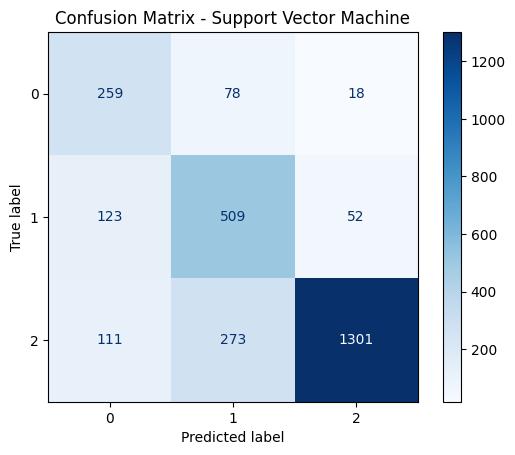


Extra Trees
Accuracy: 0.7665
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.76      0.60       355
           1       0.68      0.54      0.60       684
           2       0.88      0.86      0.87      1685

    accuracy                           0.77      2724
   macro avg       0.69      0.72      0.69      2724
weighted avg       0.78      0.77      0.77      2724



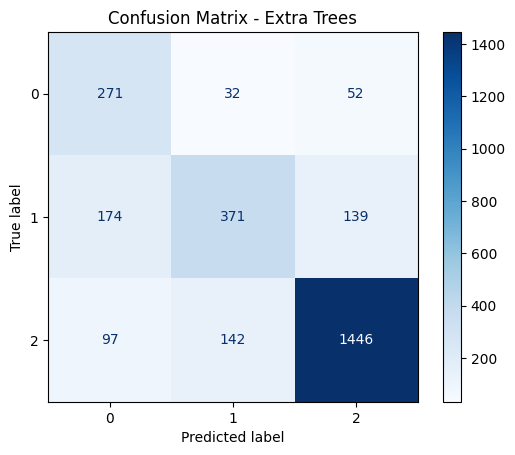


LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100744
[LightGBM] [Info] Number of data points in the train set: 20313, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Accuracy: 0.7952
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65       355
           1       0.65      0.71      0.68       684
           2       0.90      0.86      0.88      1685

    accuracy                           0.80      2724
   macro avg       0.73      0.74      0.74      2724
weighted avg       0.80      0.80      0.80      2724



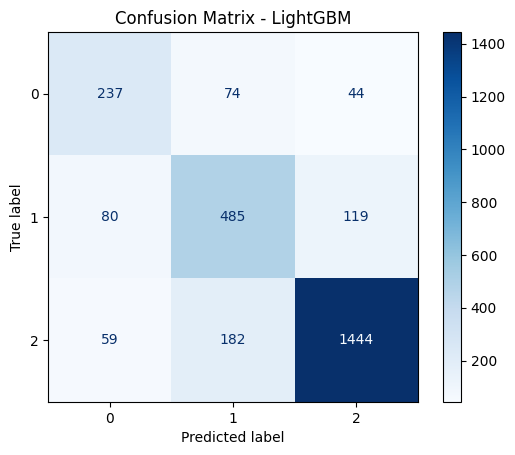


XGBoost
Accuracy: 0.7856
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.68      0.63       355
           1       0.64      0.71      0.68       684
           2       0.91      0.84      0.87      1685

    accuracy                           0.79      2724
   macro avg       0.71      0.74      0.73      2724
weighted avg       0.80      0.79      0.79      2724



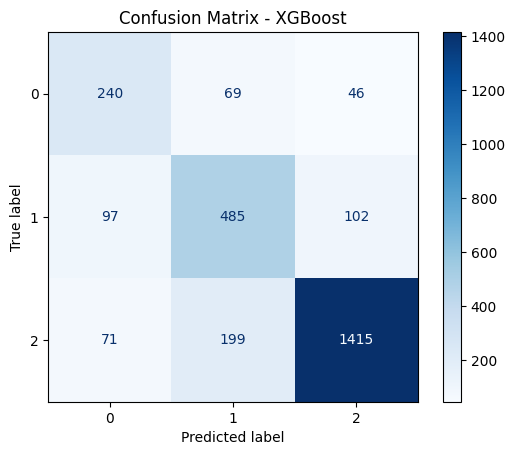


Summary:
                 Model  Accuracy
              LightGBM  0.795154
               XGBoost  0.785609
         Random Forest  0.775330
   Logistic Regression  0.772026
           Extra Trees  0.766520
Support Vector Machine  0.759545
  K Nearest Neighbours  0.579662


In [ ]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', C=1.0, class_weight='balanced'),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5,
        class_weight='balanced', random_state=42
    ),
    
    'K Nearest Neighbours': KNeighborsClassifier(
        n_neighbors=5, weights='distance', metric='minkowski', p=2
    ),
    
    'Support Vector Machine': SVC(
        kernel='rbf', C=1.0, gamma='scale', probability=True, class_weight='balanced'
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5, class_weight='balanced', random_state=42
    ),
    
    'LightGBM': LGBMClassifier(
        n_estimators=100, max_depth=10, learning_rate=0.1, class_weight='balanced', random_state=42
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1, scale_pos_weight=2,  # scale_pos_weight podbija wagę klasy mniejszościowej
        subsample=0.8, colsample_bytree=0.8, eval_metric='mlogloss', use_label_encoder=False, random_state=42
    )
}


results = []

for name, model in models.items():
    print(f"\n{name}")
    
    # SMOTE + Classifier pipeline
    smote_model_pipeline = ImbPipeline([
        ('smote', SMOTE()),
        ('classifier', model)
    ])
    
    # Fit and predict
    smote_model_pipeline.fit(X_train_features, y_train_enc)
    y_pred = smote_model_pipeline.predict(X_test_features)
    
    # Evaluation
    acc = accuracy_score(y_test_enc, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_enc, y_pred))

    cm = confusion_matrix(y_test_enc, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    results.append({
        'Model': name,
        'Accuracy': acc
    })

# Show all results in a table
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\nSummary:")
print(results_df.to_string(index=False))



## Grid search - znajujemy najlepszy model z najlepszymi hiperparametrami

Fitting 3 folds for each of 14 candidates, totalling 42 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=0.1, classifier__class_weight={'negative': 2, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=0.1, classifier__class_weight={'negative': 2, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=0.1, classifier__class_weight={'negative': 2, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=1, classifier__class_weight={'negative': 2, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=1, classifier__class_weight={'negative': 2, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=1, classifier__class_weight={'negative': 2, 'neutral': 1, 'positive': 1}; total time=   0.0s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=0.1, classifier__class_weight=balanced; total time=   1.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=0.1, classifier__class_weight=balanced; total time=   1.1s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=0.1, classifier__class_weight=balanced; total time=   1.1s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=10, classifier__class_weight={'negative': 2, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=10, classifier__class_weight={'negative': 2, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=10, classifier__class_weight={'negative': 2, 'neutral': 1, 'positive': 1}; total time=   0.0s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=1, classifier__class_weight=balanced; total time=   2.3s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=1, classifier__class_weight=balanced; total time=   2.4s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=1, classifier__class_weight=balanced; total time=   2.4s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=10, classifier__class_weight=balanced; total time=   3.5s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=10, classifier__class_weight=balanced; total time=   3.6s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=10, classifier__class_weight=balanced; total time=   2.8s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=10, classifier__n_estimators=100; total time=   7.4s
[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=10, classifier__n_estimators=100; total time=   7.3s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=None, classifier__n_estimators=100; total time=  11.8s
[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=None, classifier__n_estimators=100; total time=  12.0s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=None, classifier__n_estimators=100; total time=  11.7s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=10, classifier__n_estimators=100; total time=   7.6s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=20, classifier__n_estimators=100; total time=  10.5s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=None, classifier__n_estimators=200; total time=  22.5s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=None, classifier__n_estimators=200; total time=  23.2s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=10, classifier__n_estimators=200; total time=  14.9s
[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=None, classifier__n_estimators=200; total time=  22.6s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:46:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=10, classifier__n_estimators=200; total time=  14.6s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=10, classifier__n_estimators=200; total time=  15.0s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=20, classifier__n_estimators=100; total time=  10.4s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:46:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time=   5.7s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:46:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time=   6.0s
[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
            

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:46:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=20, classifier__n_estimators=100; total time=  11.1s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=20, classifier__n_estimators=200; total time=  20.3s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=20, classifier__n_estimators=200; total time=  20.5s
[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=20, classifier__n_estimators=200; total time=  20.3s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=100; total time=  22.5s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=100; total time=  21.4s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=100; total time=  20.7s
Najlepsze parametry: {'classifier': LogisticRegression(max_iter=1000), 'classifier__C': 0.1, 

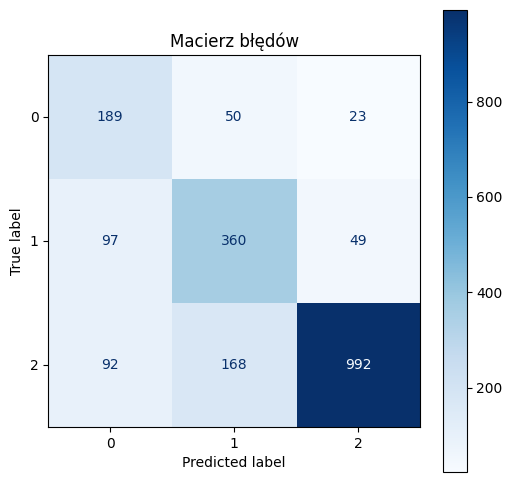

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score, make_scorer, recall_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE


# --- 2. Pipeline bazowy bez klasyfikatora
base_pipeline = ImbPipeline([
        #('smote', SMOTE()),
        ('classifier', LogisticRegression()) #placeholder
    ])

# Parametry do przetestowania
param_grid = [
    {
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [0.1, 1, 10],
        'classifier__class_weight': [
            'balanced',
            {'negative': 2, 'neutral': 1, 'positive': 1}
        ]
    },
    {
        'classifier': [RandomForestClassifier(random_state=0)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')],
        'classifier__n_estimators': [100],
        'classifier__max_depth': [3, 6],
        'classifier__learning_rate': [0.1]
     }
    #,
    # {
    #     'classifier': [SVC(probability=True)],
    #     'classifier__C': [1, 10],
    #     'classifier__kernel': ['linear']     ## Długie wywołanie, słabe efekty
    # }
]

# --- 4. Własny scorer: recall tylko dla klasy 'negative'
def negative_recall_score(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=['negative'], average='macro')

neg_recall_scorer = make_scorer(negative_recall_score)

# --- 5. GridSearchCV
grid = GridSearchCV(
    estimator=base_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=neg_recall_scorer,
    n_jobs=-1,
    verbose=2
)

# --- 6. Trening
grid.fit(X_train_features, y_train_enc)

# --- 7. Ewaluacja
y_pred = grid.predict(X_test_features)

print("Najlepsze parametry:", grid.best_params_)

print(classification_report(y_test_enc, y_pred))
print(f"Accuracy: {accuracy_score(y_test_enc, y_pred):.4f}")
print(f"F2-score (macro): {fbeta_score(y_test_enc, y_pred, beta=2, average='macro'):.4f}")
print(f"F2-score (weighted): {fbeta_score(y_test_enc, y_pred, beta=2, average='weighted'):.4f}")

# --- 8. Macierz błędów
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów")
plt.show()

In [30]:
from imblearn.pipeline import Pipeline as ImbPipeline

best_model = ImbPipeline(steps=[
    ('features', combined_features),
    #('smote', SMOTE(random_state=0)),
    ('classifier', LogisticRegression(max_iter=1000, C=0.1, class_weight={'negative': 2, 'neutral': 1, 'positive': 1}))
])

best_model.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('bert',
                                                                  BertSentenceEmbedding())])),
                                                ('custom',
                                                 Pipeline(steps=[('custom',
                                                                  CustomFeatureExtractor()),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier',
                 LogisticRegression(C=0.1,
                                    class_weight={'negative': 2, 'neutral': 1,
                                                  'positive': 1},
                                    max_iter=1000))])

Randomized search zamiast Grid Search zaproponowany przez zespół walidacyjny: większa ilość parametrów

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:48:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:48:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:48:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.

[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.5102922471479012, classifier__learning_rate=0.3009729556485983, classifier__max_depth=6, classifier__n_estimators=207, classifier__subsample=0.6061695553391381; total 

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:48:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.5102922471479012, classifier__learning_rate=0.3009729556485983, classifier__max_depth=6, classifier__n_estimators=207, classifier__subsample=0.6061695553391381; total 

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.8982714934301164, classifier__learning_rate=0.06503043695984914, classifier__max_depth=7, classifier__n_estimators=70, classifier__subsample=0.5780093202212182; total 

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.8982714934301164, classifier__learning_rate=0.06503043695984914, classifier__max_depth=7, classifier__n_estimators=70, classifier__subsample=0.5780093202212182; total 

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.8982714934301164, classifier__learning_rate=0.06503043695984914, classifier__max_depth=7, classifier__n_estimators=70, classifier__subsample=0.5780093202212182; total 

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.5499874579090014, classifier__learning_rate=0.14777466758976016, classifier__max_depth=7, classifier__n_estimators=149, classifier__subsample=0.5714334089609704; total

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.5499874579090014, classifier__learning_rate=0.14777466758976016, classifier__max_depth=7, classifier__n_estimators=149, classifier__subsample=0.5714334089609704; total

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.5102922471479012, classifier__learning_rate=0.3009729556485983, classifier__max_depth=6, classifier__n_estimators=207, classifier__subsample=0.6061695553391381; total 

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=268; total time=  32.3s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=268; total time=  33.1s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=0.47450412719997725, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=0.47450412719997725, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=0.47450412719997725, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=268; total time=  32.7s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:49:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:49:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.6999304858576277, classifier__learning_rate=0.023999698964084628, classifier__max_depth=6, classifier__n_estimators=257, classifier__subsample=0.6163856702151521; tota

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:49:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.6999304858576277, classifier__learning_rate=0.023999698964084628, classifier__max_depth=6, classifier__n_estimators=257, classifier__subsample=0.6163856702151521; tota

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.5852620618436457, classifier__learning_rate=0.029515477895583855, classifier__max_depth=6, classifier__n_estimators=138, classifier__subsample=0.9828160165372797; tota

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.5852620618436457, classifier__learning_rate=0.029515477895583855, classifier__max_depth=6, classifier__n_estimators=138, classifier__subsample=0.9828160165372797; tota

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_split=3, classifier__n_estimators=102; total time=   5.5s
[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_split=3, classifier__n_estimators=102; total time=   5.6s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_split=3, classifier__n_estimators=102; total time=   5.4s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=8.341949117361644, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=8.341949117361644, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=8.341949117361644, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.0s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_split=9, classifier__n_estimators=181; total time=   9.8s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_split=9, classifier__n_estimators=181; total time=   9.7s
[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=5, classifier__max_features=log2, classifier__min_samples_split=6, classifier__n_estimators=240; total time=   5.5s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_split=9, classifier__n_estimators=181; total time=   9.7s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=5, classifier__max_features=log2, classifier__min_samples_split=6, classifier__n_estimators=240; total time=   5.6s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=5, classifier__max_features=log2, classifier__min_samples_split=6, classifier__n_estimators=240; total time=   5.4s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=5, classifier__max_features=log2, classifier__min_samples_split=3, classifier__n_estimators=239; total time=   5.5s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=5, classifier__max_features=log2, classifier__min_samples_split=3, classifier__n_estimators=239; total time=   5.5s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=5, classifier__max_features=log2, classifier__min_samples_split=3, classifier__n_estimators=239; total time=   5.7s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=15, classifier__max_features=sqrt, classifier__min_samples_split=7, classifier__n_estimators=89; total time=  10.0s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=15, classifier__max_features=sqrt, classifier__min_samples_split=7, classifier__n_estimators=89; total time=  10.1s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=3.89677289689482, classifier__class_weight={'negative': 2, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=3.89677289689482, classifier__class_weight={'negative': 2, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=3.89677289689482, classifier__class_weight={'negative': 2, 'neutral': 1, 'positive': 1}; total time=   0.0s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:50:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=15, classifier__max_features=sqrt, classifier__min_samples_split=7, classifier__n_estimators=89; total time=  10.4s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:50:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.9143687545759647, classifier__learning_rate=0.11702599800807678, classifier__max_depth=6, classifier__n_estimators=237, classifier__subsample=0.7713480415791243; total

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:51:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.9143687545759647, classifier__learning_rate=0.11702599800807678, classifier__max_depth=6, classifier__n_estimators=237, classifier__subsample=0.7713480415791243; total

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=2.9727350570408237, classifier__class_weight=balanced; total time=   0.8s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=2.9727350570408237, classifier__class_weight=balanced; total time=   0.8s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=2.9727350570408237, classifier__class_weight=balanced; total time=   0.7s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=0.16636406741193932, classifier__class_weight=balanced; total time=   0.3s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=0.16636406741193932, classifier__class_weight=balanced; total time=   0.3s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=0.16636406741193932, classifier__class_weight=balanced; total time=   0.3s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=1.997156815341724, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=1.997156815341724, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=1.997156815341724, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.0s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.5994212020444025, classifier__learning_rate=0.223402585824595, classifier__max_depth=5, classifier__n_estimators=82, classifier__subsample=0.8029799873905057; total ti

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.5994212020444025, classifier__learning_rate=0.223402585824595, classifier__max_depth=5, classifier__n_estimators=82, classifier__subsample=0.8029799873905057; total ti

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=113; total time= 3.4min


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.5994212020444025, classifier__learning_rate=0.223402585824595, classifier__max_depth=5, classifier__n_estimators=82, classifier__subsample=0.8029799873905057; total ti

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_split=5, classifier__n_estimators=184; total time=  10.1s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.9143687545759647, classifier__learning_rate=0.11702599800807678, classifier__max_depth=6, classifier__n_estimators=237, classifier__subsample=0.7713480415791243; total

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=113; total time= 3.5min


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_split=5, classifier__n_estimators=184; total time=  10.2s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_split=5, classifier__n_estimators=184; total time=  10.2s


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=113; total time= 3.5min


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=20, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=153; total time= 7.2min


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=20, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=153; total time= 7.2min
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=9.727120953891037, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=9.727120953891037, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=9.727120953891037, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.0s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=7.227295211648732, classifier__class_weight={'negative': 3, 'neutral': 1, 'positive': 1}; total time=   0.1s
[CV] END classifier=LogisticRegression(max_iter=1000), classifier__C=7.227295211648732, c

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:59:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=15, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=248; total time= 9.9min


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=20, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=153; total time= 7.2min


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=15, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=248; total time= 9.9min


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=15, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=248; total time= 9.9min


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.6280341613806619, classifier__learning_rate=0.022130076861529402, classifier__max_depth=9, classifier__n_estimators=64, classifier__subsample=0.5554454104059157; total

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.6280341613806619, classifier__learning_rate=0.022130076861529402, classifier__max_depth=9, classifier__n_estimators=64, classifier__subsample=0.5554454104059157; total

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__colsample_bytree=0.6280341613806619, classifier__learning_rate=0.022130076861529402, classifier__max_depth=9, classifier__n_estimators=64, classifier__subsample=0.5554454104059157; total

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_split=2, classifier__n_estimators=276; total time= 8.2min


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_split=2, classifier__n_estimators=276; total time= 8.2min


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END classifier=RandomForestClassifier(random_state=0), classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_split=2, classifier__n_estimators=276; total time= 5.0min
Najlepsze parametry: {'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_

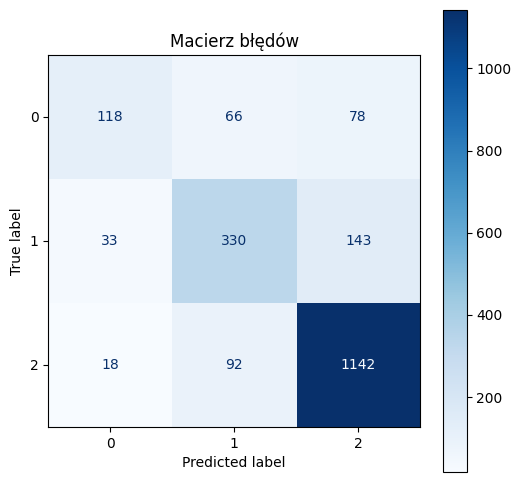

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import numpy as np

# --- Randomized param grid
param_distributions = [
    {
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': uniform(0.01, 10),  # z rozkładu ciągłego
        'classifier__class_weight': [
            'balanced',
            {'negative': 2, 'neutral': 1, 'positive': 1},
            {'negative': 3, 'neutral': 1, 'positive': 1}
        ]
    },
    {
        'classifier': [RandomForestClassifier(random_state=0)],
        'classifier__n_estimators': randint(50, 300),
        'classifier__max_depth': [None] + list(range(5, 25, 5)),
        'classifier__min_samples_split': randint(2, 10),
        'classifier__max_features': ['sqrt', 'log2', None]
    },
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')],
        'classifier__n_estimators': randint(50, 300),
        'classifier__max_depth': randint(3, 10),
        'classifier__learning_rate': uniform(0.01, 0.3),
        'classifier__subsample': uniform(0.5, 0.5),  # czyli z przedziału [0.5, 1.0]
        'classifier__colsample_bytree': uniform(0.5, 0.5)
    }
]

# --- RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_pipeline,
    param_distributions=param_distributions,
    n_iter=30,  # np. 30 losowych kombinacji – możesz zwiększyć
    cv=3,
    scoring=neg_recall_scorer,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# --- Trening
random_search.fit(X_train_features, y_train_enc)

# --- Ewaluacja
y_pred = random_search.predict(X_test_features)

print("Najlepsze parametry:", random_search.best_params_)

print(classification_report(y_test_enc, y_pred))
print(f"Accuracy: {accuracy_score(y_test_enc, y_pred):.4f}")
print(f"F2-score (macro): {fbeta_score(y_test_enc, y_pred, beta=2, average='macro'):.4f}")
print(f"F2-score (weighted): {fbeta_score(y_test_enc, y_pred, beta=2, average='weighted'):.4f}")

# --- Macierz błędów
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów")
plt.show()


In [49]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# Step 1: Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 

# Step 2: Define your pipeline
best_model_XGBC = ImbPipeline(steps=[
    ('features', combined_features),
    # ('smote', SMOTE(random_state=0)),
    ('classifier', XGBClassifier(
        eval_metric='mlogloss',
        use_label_encoder=False,
        colsample_bytree=0.8982714934301164,
        learning_rate=0.06503043695984914,
        max_depth=7,
        n_estimators=70,
        subsample=0.5780093202212182,
        random_state=42
    ))
])

# Step 3: Fit the pipeline
best_model_XGBC.fit(X_train, y_train_encoded)

# Step 4: Predict and decode labels (optional)
y_pred_encoded_xgbc = best_model_XGBC.predict(X_test)
y_pred_labels_xgbc = label_encoder.inverse_transform(y_pred_encoded_xgbc)



📌 Najlepszy próg dla 'negative': 0.20
Precision: 0.3952, Recall: 0.8779, F2: 0.7055


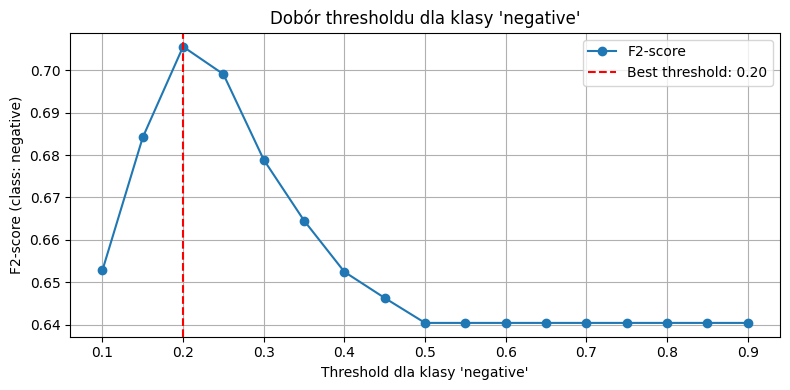

              precision    recall  f1-score   support

    negative       0.40      0.88      0.55       262
     neutral       0.79      0.42      0.55       506
    positive       0.90      0.84      0.87      1252

    accuracy                           0.74      2020
   macro avg       0.70      0.71      0.66      2020
weighted avg       0.81      0.74      0.75      2020



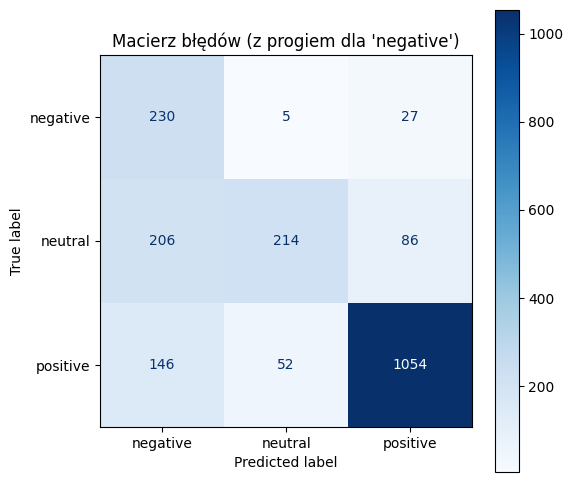

In [ ]:
from sklearn.metrics import precision_score, recall_score, fbeta_score


y_proba = best_model.predict_proba(X_test)
classes = best_model.classes_
neg_index = list(classes).index('negative')

thresholds = np.arange(0.1, 0.91, 0.05)
scores = []

for thresh in thresholds:
    y_pred_thresh = []
    for i in range(len(y_proba)):
        if y_proba[i][neg_index] >= thresh:
            y_pred_thresh.append('negative')
        else:
            y_pred_thresh.append(classes[np.argmax(y_proba[i])])
    
    # 🔄 Zrób z tego klasy binarne: 'negative' vs 'other'
    y_test_binary = ['negative' if label == 'negative' else 'other' for label in y_test]
    y_pred_binary = ['negative' if label == 'negative' else 'other' for label in y_pred_thresh]
    
    precision = precision_score(y_test_binary, y_pred_binary, pos_label='negative', average='binary')
    recall = recall_score(y_test_binary, y_pred_binary, pos_label='negative', average='binary')
    f2 = fbeta_score(y_test_binary, y_pred_binary, beta=2, pos_label='negative', average='binary')
    
    scores.append((thresh, precision, recall, f2))
# Najlepszy próg
best = max(scores, key=lambda x: x[3])
best_thresh = best[0]
print(f"Najlepszy próg dla 'negative': {best_thresh:.2f}")
print(f"Precision: {best[1]:.4f}, Recall: {best[2]:.4f}, F2: {best[3]:.4f}")

# Wykres
plt.figure(figsize=(8, 4))
plt.plot(thresholds, [x[3] for x in scores], marker='o', label='F2-score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best threshold: {best_thresh:.2f}')
plt.xlabel("Threshold dla klasy 'negative'")
plt.ylabel("F2-score (class: negative)")
plt.title("Dobór thresholdu dla klasy 'negative'")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

    # Finalna predykcja
y_pred_custom = []
for i in range(len(y_proba)):
    if y_proba[i][neg_index] >= best_thresh:
        y_pred_custom.append('negative')
    else:
        y_pred_custom.append(classes[np.argmax(y_proba[i])])

# Ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score

print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów (z progiem dla 'negative')")
plt.show()


### Stacking model

In [ ]:
# przygotowanie stacking
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier

def get_stacking():
    
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('cart', DecisionTreeClassifier(random_state=1)))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('rf', RandomForestClassifier(n_estimators=1000, # Ilość słabych estymatorów
                                      max_depth=2, # Maksymalna wysokość drzewa w słabym estymatorze
                                      min_samples_split = 2, # Minimalna ilość obserwacji wymagana do podziału węzła
                                      max_features = 3, # Maksymalna ilość zmiennych brana pod uwagę przy podziale węzła
                                      random_state=0,
                                      n_jobs = -1)))
    # level0.append(('gboost', GradientBoostingClassifier(random_state=1,
    #                                   learning_rate=0.01)))
    level0.append(('xgb', XGBClassifier(random_state=1,
                        learning_rate=0.01, # Szybkość "uczenia" się
                        booster='gbtree', # Jaki model wykorzystujemy (drzewo - gbtree, liniowe - gblinear)
                        max_depth=4 # Maksymalna głębokość drzewa 
                        )))
    
    # definicja meta learner model
    level1 = LogisticRegression()
    
    # definicja stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    
    return model

In [ ]:
model = get_stacking()

pipeline_for_stacking = ImbPipeline(steps=[
    ('features', combined_features),
    #('smote', SMOTE(random_state=0)),
    ('classifier', model)
])

In [ ]:
# Fit and predict
pipeline_for_stacking.fit(X_train, y_train_enc)
y_pred = pipeline_for_stacking.predict(X_test)

# Evaluation
acc = accuracy_score(y_test_enc, y_pred)
print(f"Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test_enc, y_pred))

print('Accuracy for stacking model: ', acc)

Accuracy: 0.7654
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.57      0.54       355
           1       0.60      0.70      0.65       684
           2       0.92      0.83      0.87      1685

    accuracy                           0.77      2724
   macro avg       0.68      0.70      0.69      2724
weighted avg       0.78      0.77      0.77      2724

Accuracy for stacking model:  0.7654185022026432


## Które z cech mają najwięskzy wpływ na predykcję?

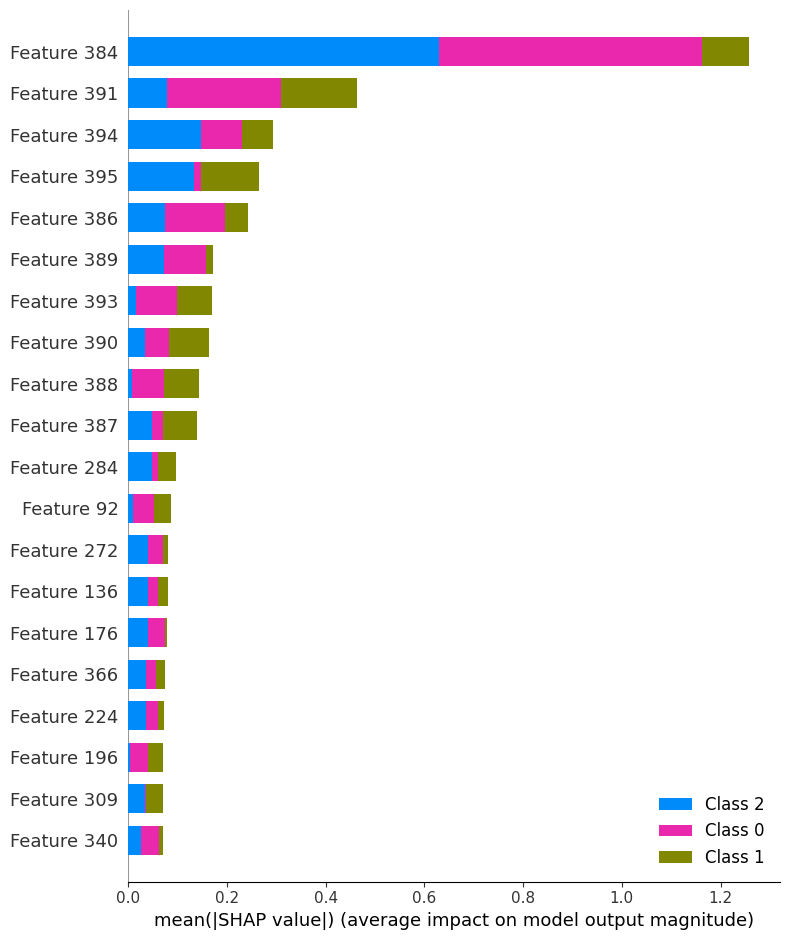

In [ ]:
import shap

X_transformed = best_model.named_steps['features'].transform(X_train)

explainer = shap.Explainer(best_model.named_steps['classifier'], X_transformed)
shap_values = explainer(X_transformed)

shap.summary_plot(shap_values, X_transformed)


--> największy wpływ na predykcję mają kolumny z bert (tak samo z tfidf jeśli używany)

### Dopasowywanie hiperparametrów dla modelu LightGBM - w teori ma lepiej sobie radzić ze zbiorami niezbalansownymi

In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from imblearn.pipeline import Pipeline as ImbPipeline  # Ensure you use imbalanced pipeline

# Define the pipeline
best_model = ImbPipeline(steps=[
    ('features', combined_features),  # Your feature extraction
    #('smote', SMOTE(random_state=0)),  # Optional: Handle class imbalance with SMOTE
    ('classifier', lgb.LGBMClassifier(class_weight='balanced', max_iter=1000))  # LightGBM classifier
])

# Smaller, faster grid
param_grid = {
    'classifier__num_leaves': [31, 50],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [-1, 10]
}

# Total combinations: 2×2×2×2 = 16 models × 5 folds = 80 fits

grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99735
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99681
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99666
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99666
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start t

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99745
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99672
[LightGBM] [Info] Number of data points in the train set: 8716, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99681
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training fr

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 in

[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99735
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99666
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start trai

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib

[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99681
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99672
[LightGBM] [Info] Number of data points in the train set: 8716, number of used features: 396
[LightGBM] [Info] Start trai

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99735
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99672
[LightGBM] [Info] Number of data points in the train set: 8716, number of used features: 396
[LightGBM] [Info] Start trai

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib

[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99745
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99681
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99735
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99672
[LightGBM] [Info] Number of data points in the train set: 8716, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99666
[LightGBM] [Info] Number of data points in the train set:

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99745
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99681
[LightGBM] [Info] Number of data points in the train set:

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99735
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99672
[LightGBM] [Info] Number of data points in the train set: 8716, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib

[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99666
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99681
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99745
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start trai

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99735
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99672
[LightGBM] [Info] Number of data points in the train set: 8716, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99666
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99681
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib

[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99735
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99672
[LightGBM] [Info] Number of data points in the train set: 8716, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99681
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start trai

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99672
[LightGBM] [Info] Number of data points in the train set: 8716, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99666
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start trai

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99745
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99735
[LightGBM] [I

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99745
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99681
[LightGBM] [Info] Number of data points in the train set:

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99745
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99672
[LightGBM] [Info] Number of data points in the train set: 8716, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047718 secon

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99745
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99681
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start trai

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99748
[LightGBM] [Info] Number of data points in the train set: 10894, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Najlepszy z modli LightGBM


LightGBM


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99748
[LightGBM] [Info] Number of data points in the train set: 10894, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Accuracy: 0.7882
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       355
           1       0.64      0.70      0.67       684
           2       0.91      0.85      0.88      1685

    accuracy                           0.79      2724
   macro avg       0.72      0.74      0.73      2724
weighted avg       0.80      0.79      0.79      2724



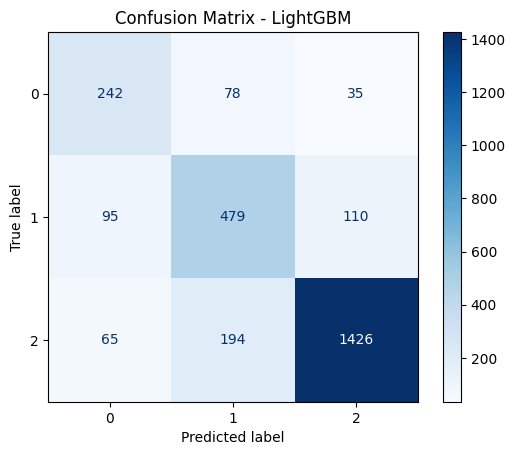


Summary:
   Model  Accuracy
LightGBM  0.788179


In [ ]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline 

models = {
    'LightGBM': LGBMClassifier(
        n_estimators=100, max_depth=10, learning_rate=0.1, class_weight='balanced', num_leaves=31, random_state=42
    )
}

results = []

for name, model in models.items():
    print(f"\n{name}")
    
    # SMOTE + Classifier pipeline
    pipeline = ImbPipeline(steps=[
    ('features', combined_features),
    ('classifier', model)
])
    
    # Fit and predict
    pipeline.fit(X_train, y_train_enc)
    y_pred = pipeline.predict(X_test)
    
    # Evaluation
    acc = accuracy_score(y_test_enc, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_enc, y_pred))

    cm = confusion_matrix(y_test_enc, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    results.append({
        'Model': name,
        'Accuracy': acc
    })

# Show all results in a table
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\nSummary:")
print(results_df.to_string(index=False))

Wyniki dla zbioru treningowego nie są lepsze niż w regresji logistycznej

In [ ]:
print()

## Porównanie najlepszych modeli dla danych testowych test_df

### Logistic Regression

In [56]:
best_model_logistic_regression = ImbPipeline(steps=[
    ('features', combined_features), 
    #('smote', SMOTE(random_state=0)), 
    ('classifier', LogisticRegression(
        max_iter=1000, 
        C=0.1, 
        class_weight={'negative': 2, 'neutral': 1, 'positive': 1}
    ))
])


best_model_logistic_regression.fit(X_train, y_train)



Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('bert',
                                                                  BertSentenceEmbedding())])),
                                                ('custom',
                                                 Pipeline(steps=[('custom',
                                                                  CustomFeatureExtractor()),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier',
                 LogisticRegression(C=0.1,
                                    class_weight={'negative': 2, 'neutral': 1,
                                                  'positive': 1},
                                    max_iter=1000))])

In [57]:
y_proba_test = best_model_logistic_regression.predict_proba(test_df)

y_pred_test_custom = []

for i in range(len(y_proba_test)):
    if y_proba_test[i][neg_index] >= best_thresh:
        y_pred_test_custom.append('negative')
    else:
        y_pred_test_custom.append(classes[np.argmax(y_proba_test[i])])

test_df['predicted_label'] = y_pred_test_custom

In [58]:
test_df.head()

Comment Sentiment  \
2917                             i love the makeup look   positive   
8743   thank you so much for sharing love this channe...  positive   
14132  i’m eleven years old and wanting to get a star...  positive   
12230  my prediction 790 math i will miss 1 question ...  negative   
2540                                       love you bor   positive   

      predicted_label  
2917         positive  
8743         positive  
14132        positive  
12230        negative  
2540         positive

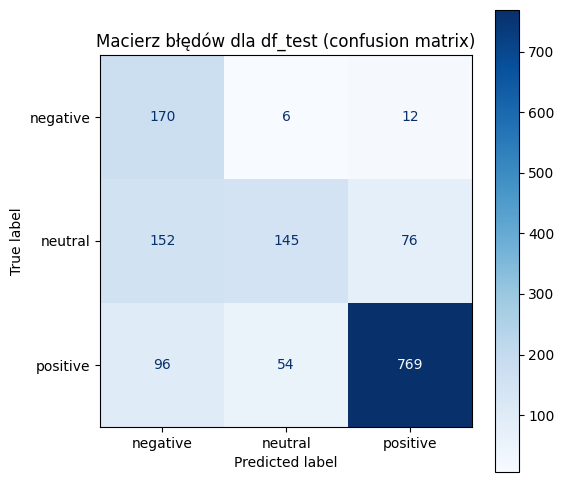

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = test_df['Sentiment']

cm = confusion_matrix(y_true, y_pred_test_custom, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów dla df_test (confusion matrix)")
plt.show()


In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_test_custom, digits=4))

y_true_binary = ['negative' if label == 'negative' else 'other' for label in y_true]
y_pred_binary = ['negative' if label == 'negative' else 'other' for label in y_pred_test_custom]

f2_negative = fbeta_score(y_true_binary, y_pred_binary, beta=2, pos_label='negative', average='binary')

print(f"F2-score for 'negative' class: {f2_negative:.4f}")


              precision    recall  f1-score   support

    negative     0.4067    0.9043    0.5611       188
     neutral     0.7073    0.3887    0.5017       373
    positive     0.8973    0.8368    0.8660       919

    accuracy                         0.7324      1480
   macro avg     0.6704    0.7099    0.6429      1480
weighted avg     0.7871    0.7324    0.7355      1480

F2-score for 'negative' class: 0.7265


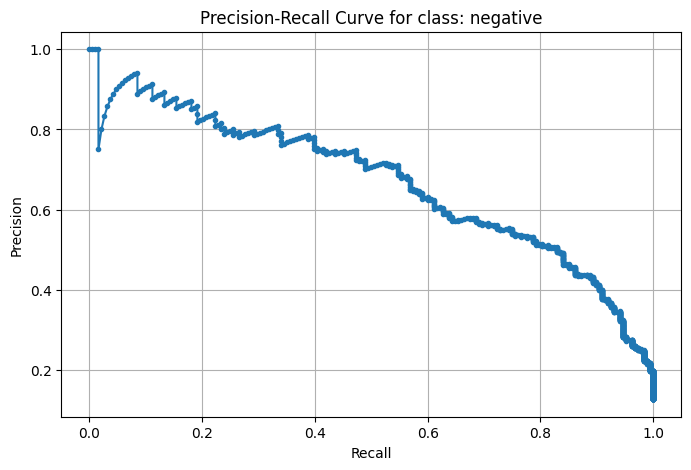

In [61]:
from sklearn.metrics import precision_recall_curve

# 'negative' = 1, others = 0
y_true_binary = [1 if label == 'negative' else 0 for label in y_true]
y_scores_neg = [proba[neg_index] for proba in y_proba_test]

precision, recall, thresholds = precision_recall_curve(y_true_binary, y_scores_neg)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for class: negative')
plt.grid()
plt.show()


#### LGBMClassifier

In [62]:
from lightgbm import LGBMClassifier

best_model_lightGBM = ImbPipeline(steps=[
    ('features', combined_features), 
    #('smote', SMOTE(random_state=0)),
    ('classifier', LGBMClassifier(
        n_estimators=100, max_depth=10, learning_rate=0.1, class_weight='balanced', num_leaves=31, random_state=42
    ))
])

best_model_lightGBM.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99676
[LightGBM] [Info] Number of data points in the train set: 8079, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('bert',
                                                                  BertSentenceEmbedding())])),
                                                ('custom',
                                                 Pipeline(steps=[('custom',
                                                                  CustomFeatureExtractor()),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier',
                 LGBMClassifier(class_weight='balanced', max_depth=10,
                                random_state=42))])

In [63]:
y_proba_test = best_model_lightGBM.predict_proba(test_df)

y_pred_test_custom = []

for i in range(len(y_proba_test)):
    if y_proba_test[i][neg_index] >= best_thresh:
        y_pred_test_custom.append('negative')
    else:
        y_pred_test_custom.append(classes[np.argmax(y_proba_test[i])])

test_df['predicted_label'] = y_pred_test_custom

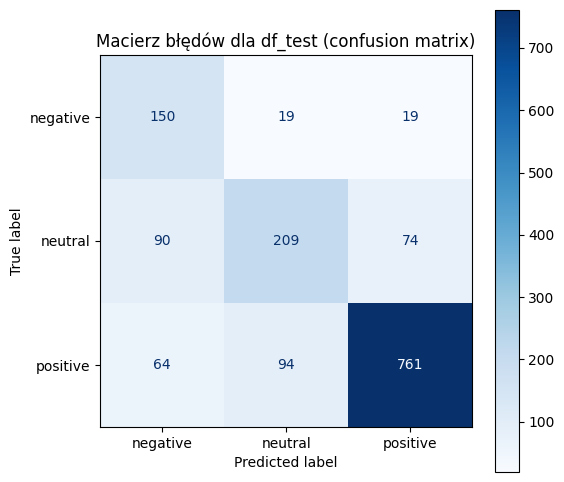

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = test_df['Sentiment']

cm = confusion_matrix(y_true, y_pred_test_custom, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów dla df_test (confusion matrix)")
plt.show()


In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_test_custom, digits=4))

y_true_binary = ['negative' if label == 'negative' else 'other' for label in y_true]
y_pred_binary = ['negative' if label == 'negative' else 'other' for label in y_pred_test_custom]

f2_negative = fbeta_score(y_true_binary, y_pred_binary, beta=2, pos_label='negative', average='binary')

print(f"F2-score for 'negative' class: {f2_negative:.4f}")

              precision    recall  f1-score   support

    negative     0.4934    0.7979    0.6098       188
     neutral     0.6491    0.5603    0.6014       373
    positive     0.8911    0.8281    0.8584       919

    accuracy                         0.7568      1480
   macro avg     0.6779    0.7288    0.6899      1480
weighted avg     0.7796    0.7568    0.7621      1480

F2-score for 'negative' class: 0.7102


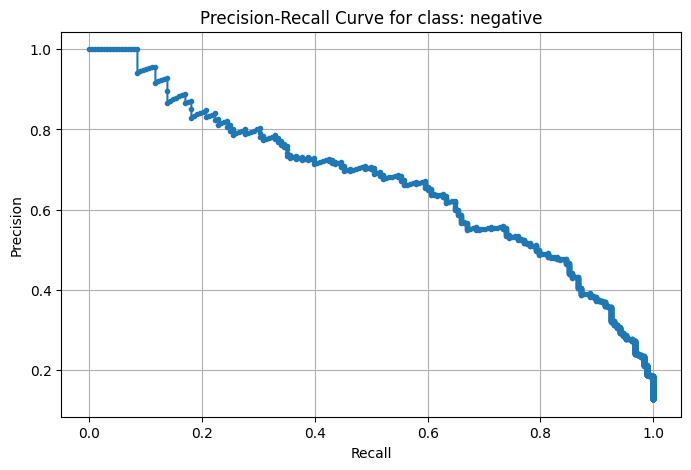

In [66]:
from sklearn.metrics import precision_recall_curve

# 'negative' = 1, others = 0
y_true_binary = [1 if label == 'negative' else 0 for label in y_true]
y_scores_neg = [proba[neg_index] for proba in y_proba_test]

precision, recall, thresholds = precision_recall_curve(y_true_binary, y_scores_neg)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for class: negative')
plt.grid()
plt.show()


#### XGBClassifier



In [67]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# Step 1: Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test) 

# Step 2: Define your pipeline
best_model_XGBC = ImbPipeline(steps=[
    ('features', combined_features),
    # ('smote', SMOTE(random_state=0)),
    ('classifier', XGBClassifier(
        eval_metric='mlogloss',
        use_label_encoder=False,
        colsample_bytree=0.8982714934301164,
        learning_rate=0.06503043695984914,
        max_depth=7,
        n_estimators=70,
        subsample=0.5780093202212182,
        random_state=42
    ))
])

# Step 3: Fit the pipeline
best_model_XGBC.fit(X_train, y_train_encoded)

# Step 4: Predict and decode labels (optional)
y_pred_encoded_xgbc = best_model_XGBC.predict(X_test)
y_pred_labels_xgbc = label_encoder.inverse_transform(y_pred_encoded_xgbc)

In [68]:
y_proba_test = best_model_XGBC.predict_proba(test_df)

y_pred_test_custom = []

for i in range(len(y_proba_test)):
    if y_proba_test[i][neg_index] >= best_thresh:
        y_pred_test_custom.append('negative')
    else:
        y_pred_test_custom.append(classes[np.argmax(y_proba_test[i])])

test_df['predicted_label'] = y_pred_test_custom

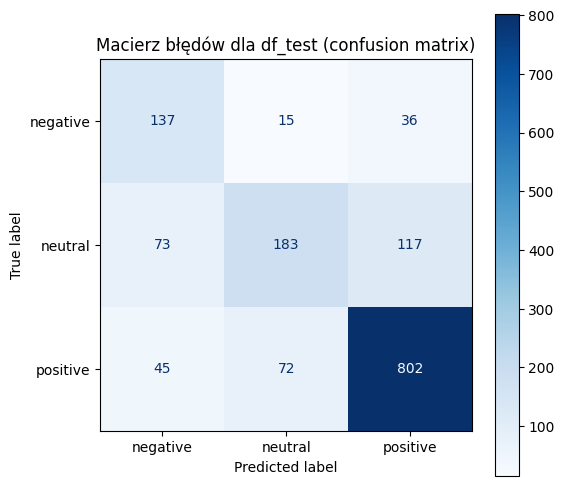

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = test_df['Sentiment']

cm = confusion_matrix(y_true, y_pred_test_custom, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów dla df_test (confusion matrix)")
plt.show()


In [70]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_test_custom, digits=4))

y_true_binary = ['negative' if label == 'negative' else 'other' for label in y_true]
y_pred_binary = ['negative' if label == 'negative' else 'other' for label in y_pred_test_custom]

f2_negative = fbeta_score(y_true_binary, y_pred_binary, beta=2, pos_label='negative', average='binary')

print(f"F2-score for 'negative' class: {f2_negative:.4f}")

              precision    recall  f1-score   support

    negative     0.5373    0.7287    0.6185       188
     neutral     0.6778    0.4906    0.5692       373
    positive     0.8398    0.8727    0.8559       919

    accuracy                         0.7581      1480
   macro avg     0.6849    0.6973    0.6812      1480
weighted avg     0.7605    0.7581    0.7535      1480

F2-score for 'negative' class: 0.6802


Pomimo o wiele lepszych wyników na zbiorze treningowym dla modelu XGBC, nie widać poprawy dla zbioru testowego. Zostajemy przy regresji logistycznej

#### Crossvalidation for lightGBM

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define your pipeline (already given)
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# Perform cross-validation
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    best_model_lightGBM,
    X_train, y_train,
    scoring='f1_macro',
    cv=cv,
    n_jobs=1  
)

print(f"Cross-validated F1 Macro scores: {scores}")
print(f"Mean F1 Macro score: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99673
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99671
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99743
[LightGBM] [Info] Number of data points in the train set: 8715, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99679
[LightGBM] [Info] Number of data points in the train set: 8716, number of used features: 396
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024586 s

/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib

Cross-validated F1 Macro scores: [0.71466268 0.7143239  0.72047564 0.70607431 0.71525578]
Mean F1 Macro score: 0.7142 ± 0.0046


/Users/lila/ml projekt 1/YouTubeCommentsClassification/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
print(np.unique(y_train, return_counts=True))


(array(['negative', 'neutral', 'positive'], dtype=object), array([1379, 2744, 6771]))


100%|===================| 32659/32682 [06:32<00:00]        

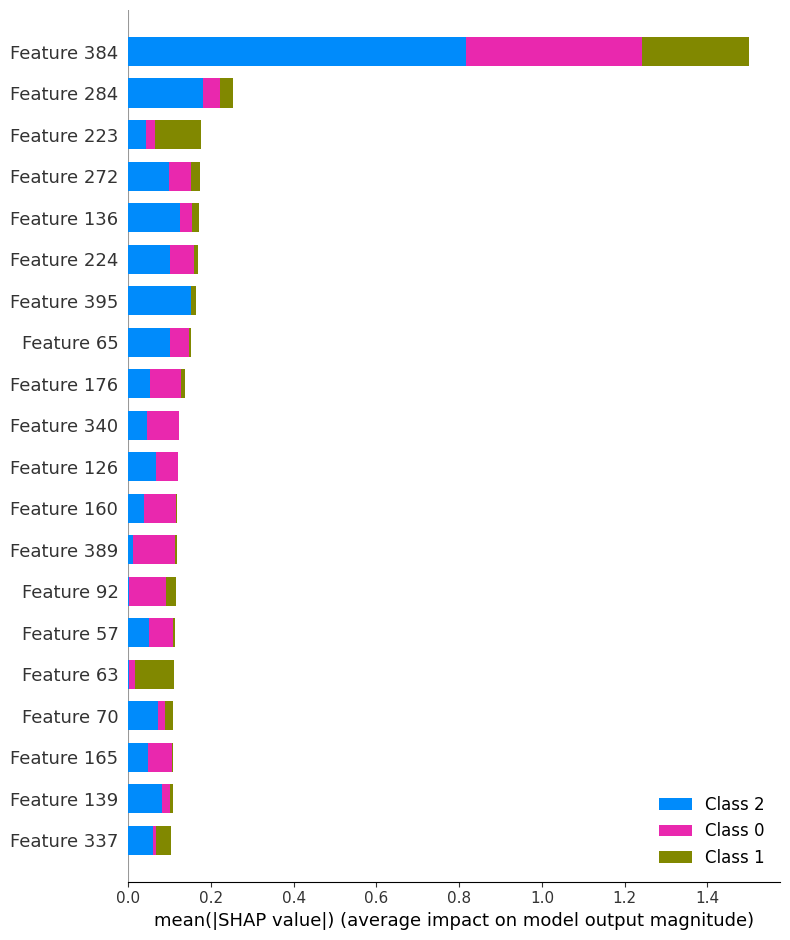

In [ ]:
import shap

X_transformed = best_model_lightGBM.named_steps['features'].transform(X_train)

explainer = shap.Explainer(best_model_lightGBM.named_steps['classifier'], X_transformed)
shap_values = explainer(X_transformed)

shap.summary_plot(shap_values, X_transformed)

# Komentarze odnośnie walidacji

-- ustawiłyśmy random seed w grid search

-- dodałyśmy randomized search jako alternatywę dla grid search -- wsakazł on model, które lepiej działa na zbiorze trningowym, lecz któregy nie otrzymuje lepszych wyników dla zbiowu testowego. Zdecydowałyśmy się zostać przy prostszym modelu.

-- wyniki dla regresji logistycznej i lightGBM potwierdzają się dla dannych walidacyjnych (XGBC nie był uwzględniony ze względu na późniejsze dodanie)

-- zostajemy przy metryce F2 score